## Example 4 (Collider): 

Here we investigate the direct, tropospheric influence of Indian Ocean Dipole (IOD) on mean precipitaion over Australia (AU) in the early summer months (OND).

Both ENSO and the IOD are key drivers of Australian climate and their influence on precipitation is well documented. Also the timing of the stratospheric polar vortex breakdown (Vortex), which is also influenced by ENSO, is known to affect precipitation in Australia by altering the jet position. We further assume that ENSO affects the IOD, as suggested by several studies. More provisionally, we also assume the IOD to affect Vortex. 

We illustrate how to disentangle the various contributions to Australian precipitation in order to isolate the direct effect of IOD.

<img src="../images/ex4.png" width="300" height="400">

## Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import iris
import iris.quickplot as qplt

import statsmodels.api as sm
from scipy import signal
from scipy.stats import pearsonr

### Step 1) Load the data

In [2]:
# data from 1950 to 2019, year 2002 was removed because it is the only SH Sudden Stratospheric Warming on record.

DATA_PATH = '../sample_data/file.nc'

au     = iris.load_cube(DATA_PATH + 'precip_AU_ond_no2002.nc')
enso   = iris.load_cube(DATA_PATH + 'enso_full_ond_no2002.nc')
iod    = iris.load_cube(DATA_PATH + 'iod_ond_no2002.nc') 
vortex = iris.load_cube(DATA_PATH + 'vortex_breakdown_no2002.nc') #'breakdown date in days after 1st Oct' )

#### Plot the data

/envs/auto-build-envs/datasci/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


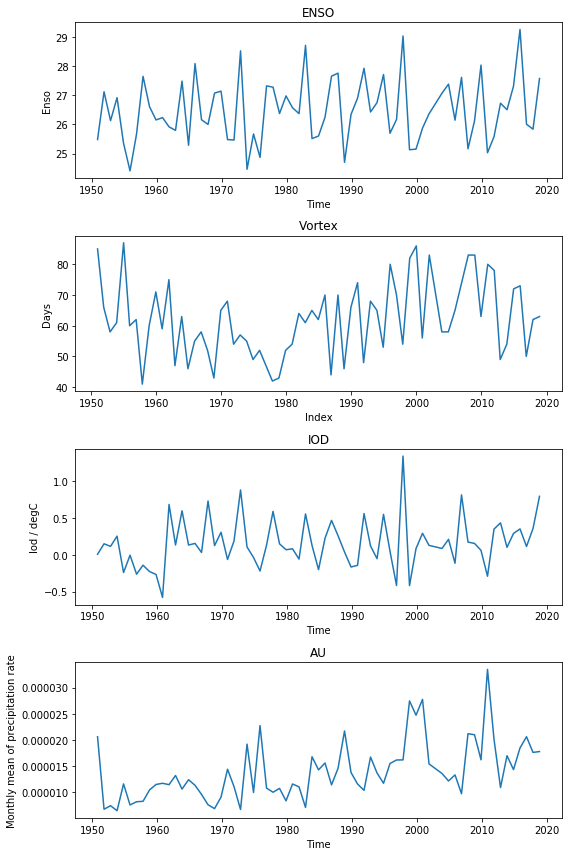

In [3]:
fig = plt.figure(figsize=(8, 12))

plt.subplot(411)
qplt.plot(enso)
plt.title('ENSO')

plt.subplot(412)
qplt.plot(vortex)
plt.title('Vortex')
plt.tight_layout()

plt.subplot(413)
qplt.plot(iod)
plt.title('IOD')

plt.subplot(414)
qplt.plot(au)
plt.title('AU')
plt.tight_layout()

### Step 2) Data analysis using regression

#### Standardize the data (zero mean, unit variance)

In [4]:
ENSO   = (enso - np.mean(enso.data))/np.std(enso.data)
VORTEX = (vortex - np.mean(vortex.data))/np.std(vortex.data)
AU     = (au - np.mean(au.data))/np.std(au.data)
IOD    = (iod - np.mean(iod.data))/np.std(iod.data)


#### Detrend

In [5]:
ENSO   = signal.detrend(ENSO.data)
VORTEX = signal.detrend(VORTEX.data)
AU     = signal.detrend(AU.data)
IOD    = signal.detrend(IOD.data)

#### Regression analysis

We are interested in quantifying the direct, tropospheric influence of IOD on AU.
First, we do this naively by controlling for Vortex only.

In [6]:
Y = AU
X = np.stack([IOD, VORTEX]).T

model = sm.OLS(Y,X)
results = model.fit()


print("AU = %.2f IOD + %.2f VORTEX \n"%(results.params[0],results.params[1]))

print("effect of IOD on AU (ENSO uncontrolled) : %.2f \n "%results.params[0])

AU = -0.26 IOD + 0.25 VORTEX 

effect of IOD on AU (ENSO uncontrolled) : -0.26 
 


In the previous regression there are two different types of biases. The first one is a common driver bias (as in Example 1): ENSO influences both IOD and AU directly but it is was not controlled for. The second bias results from conditioning on Vortex: Vortex is a common effect (or collider) of ENSO and IOD and controlling for it introduces a non-causal association between them. 

To remove both biases here we simply have to block away the influence of ENSO, i.e., we also need to include ENSO in the regression.

In [7]:
Y = AU
X = np.stack([IOD, VORTEX, ENSO]).T

model = sm.OLS(Y,X)
results_causal = model.fit()

print("AU = %.2f IOD + %.2f VORTEX + %.2f ENSO  \n"\
      %(results_causal.params[0],results_causal.params[1],results_causal.params[2]))

print("causal effect of IOD on AU : %.2f "%results_causal.params[0])

AU = -0.05 IOD + 0.19 VORTEX + -0.43 ENSO  

causal effect of IOD on AU : -0.05 


#### Conclusions
The direct tropospheric influence of IOD on AU is estimated based on the assumed causal network.
If this is attempted via controlling for Vortex only, the estimate (-0.26) is potentially biased by the 'collider effect' introduced by the Vortex. Controlling for the Vortex opens a path from IOD to ENSO and then to AU, biasing the analysis of the direct causal effect of IOD on AU. Note that also the common driver effect of ENSO on both IOD and AU may be an additional source of bias here.

Including ENSO in the regression allows to account for both biases. The effect of IOD on AU reduces to only -0.05, which is likely a more realistic estimate of its average causal effect. 

Finally, caution is needed when controlling for another process. While conditioning on a third variable is necessary to block the effect of a common driver or an indirect pathway, it can lead to confusion and bias if done for a common effect.

# Appendix

### Test the link IOD $\to$ VORTEX

In [13]:
Corr = pearsonr(IOD, VORTEX)
print('Correlation between IOD and VORTEX %.2f (pval %.3f)'%(Corr[0],Corr[1]))

Correlation between IOD and VORTEX -0.25 (pval 0.038)


In [14]:
#Conditional correlation

# get the residuals first
Y= IOD 
X= ENSO

model = sm.OLS(Y,X)
results = model.fit()

#residuals of the linear fit
res_IOD =results.resid


In [15]:
Y = VORTEX
X = ENSO

model = sm.OLS(Y,X)
results = model.fit()

#residuals of the linear fit
res_VORTEX =results.resid


In [16]:
Corr_cond = pearsonr(res_IOD , res_VORTEX)
print('Correlation between IOD and VORTEX conditioned on ENSO %.2f (pval %.3f)'%(Corr_cond[0],Corr_cond[1]))

Correlation between IOD and VORTEX conditioned on ENSO -0.13 (pval 0.275)


The probability of a regression of -0.13 if the actual link strength was zero is about 28%, which we can regard as relatively low in this context. Therefore, although reduced, the correlation between IOD and VORTEX after controlling for ENSO is still non negligible.

### More potential biases
We can estimate the ENSO effect on AU, and looking at the collider bias introduced by conditioning only on Vortex and not on IOD.

In [11]:
Y = AU
X = np.stack([VORTEX, ENSO]).T

model = sm.OLS(Y,X)
results = model.fit()

print("AU = %.2f VORTEX + %.2f ENSO \n"%(round(results.params[0],2),round(results.params[1],2)))

AU = 0.19 VORTEX + -0.46 ENSO 



The above regression is to be compared with the correct regression based on the assumed causal network:
AU = -0.05 IOD + 0.19 VORTEX -0.43 ENSO. Because the direct effect of IOD is small, the biased estimate of the effect of ENSO on AU (-0.43) is not very different from the unbiased one (-0.46). 

On the other hand, if we fail to control for Vortex

In [12]:
Y = AU
X = np.stack([IOD, ENSO]).T

model = sm.OLS(Y,X)
results = model.fit()

print("AU = %.2f IOD + %.2f ENSO \n"%(round(results.params[0],2),round(results.params[1],2)))

AU = -0.07 IOD + -0.47 ENSO 



Compared with the correct regression based on the assumed causal network, AU = -0.05 IOD + 0.19 VORTEX -0.43 ENSO, boht IOD and ENSO regression coefficents result slightly modified, with ENSO's more significantly. 

### Estimate all remaining liks in the network

In [13]:
# Target IOD
Y = IOD
X = ENSO

model = sm.OLS(Y,X)
results = model.fit()

print("IOD = %.2f ENSO \n"%(results.params[0]))

IOD = 0.53 ENSO 



In [14]:
# TARGET VORTEX
Y = VORTEX
X = np.stack([ENSO, IOD]).T

model = sm.OLS(Y,X)
results = model.fit()

print("VORTEX = %.2f ENSO + %.2f IOD \n"%(results.params[0], results.params[1]))

VORTEX = -0.18 ENSO + -0.15 IOD 

